In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as patches

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist
from pynrc import speckle_noise as sn
pynrc.setup_logging('WARNING', verbose=False)

from astropy.io import fits
from astropy.io import ascii
from copy import deepcopy

# Time Series OPDs

In [3]:
import os

def combine_opds(base_opd, delta_opd, amplitude=1.0, outname=None, verbose=True):
    opdf = fits.open(base_opd)
    deltaf = fits.open(delta_opd)

    delta = deltaf[0].data
    if verbose:
        print("Found a {} shape OPD".format(opdf[0].data.shape))
        print("Adding delta OPD from {} with scaling {}".format(delta_opd, amplitude))
    if len(opdf[0].data.shape) >2:
        for i in range(opdf[0].data.shape[0]):
            opdf[0].data[i] += delta*amplitude
            if verbose:
                print(" Adding to cube slice {}".format(i))
    else:
        opdf[0].data += delta*amplitude
        if verbose:
            print(" Adding to OPD.")
    opdf[0].header.add_history("Modified OPD by adding oscillation delta")
    opdf[0].header.add_history(" from "+delta_opd)
    opdf[0].header.add_history(" scaled by {}".format(amplitude)) 

    opdf[0].header['ORIGINAL'] = (os.path.basename(base_opd), 
                                         "Original file for this OPD")
    opdf[0].header['OFILE'] = (delta_opd, "Source file for oscillation OPD")
    opdf[0].header['OCASE'] = (deltaf[0].header['CASE'], "Oscillation model case")
    opdf[0].header['OVARIANT'] = (deltaf[0].header['VARIANT'],
                                         "Oscillation model variant")
    opdf[0].header['OAMP'] = (amplitude, "Oscillation model amplitude")

    if outname is None:
        outbase = os.path.basename(base_opd).split('.')[0]
        vnum = deltaf[0].header['VARIANT'][1]
        outname = "{}_c{}_v{}_a{:.1f}.fits".format(outbase,
                                                  deltaf[0].header['CASE'],
                                                  vnum,
                                                  amplitude)
    opdf.writeto(outname, overwrite=True)
    if verbose:
        print("Output to {}".format(outname))

    opdf.close()
    deltaf.close()

def make_series(base_opd, delta_opd, n=11, verbose=False):
    
    # Determine delta_opd name and directory info
    mod_dir  = os.path.dirname(delta_opd) + '/'
    mod_file = os.path.basename(delta_opd)
    str_list = mod_file.split('_')
    outdir = '{}time-series-{}_{}/'.format(mod_dir, str_list[2], str_list[3])
    
    # Create output directory
    if not os.path.exists(outdir):
        os.makedirs(outdir, exist_ok=True)

    # Phase information
    #phase = np.linspace(0, np.pi*2, n+1)
    # Only need -1 to 1 (1 to -1 is redundant)
    phase = np.linspace(0, np.pi, n)
    amp = np.cos(phase)

    for i in range(n):
        if verbose:
            print("Making step {} with amplitude {}".format(i, amp[i]))

        outbase = mod_file.split('.')[0]
        outname = "{}_n{:03d}.fits".format(outbase,i)
        combine_opds(base_opd, delta_opd, amplitude=amp[i], 
                     outname=outdir+outname, verbose=verbose)

In [4]:
# WebbPSF data directory and NIRCam OPD file name
webb_data_dir = pynrc.pynrc_core.webbpsf.utils.get_webbpsf_data_path() + '/'
opd_dir = webb_data_dir + 'NIRCam/OPD/'
base_opd = opd_dir + 'OPD_RevW_ote_for_NIRCam_requirements.fits'

# Get all delta OPD FITS files
mod_dir = '/Volumes/NIRData/oscillation_opd_models/'
mod_files = []
for file in os.listdir(mod_dir):
    if file.endswith(".fits"):
        mod_files.append(file)

In [5]:
# Creat time series OPD files for each Case and Variant
for mf in mod_files:
    print(mf)
    make_series(base_opd, mod_dir+mf)

oscillation_opd_case1_var1_smooth.fits
oscillation_opd_case1_var2_ptt.fits
oscillation_opd_case1_var3_piston.fits
oscillation_opd_case2_var1_smooth.fits
oscillation_opd_case2_var2_ptt.fits
oscillation_opd_case2_var3_piston.fits
oscillation_opd_case3_var1_smooth.fits
oscillation_opd_case3_var2_ptt.fits
oscillation_opd_case3_var3_piston.fits
oscillation_opd_case4_var1_smooth.fits
oscillation_opd_case4_var2_ptt.fits
oscillation_opd_case4_var3_piston.fits


# Sequence of NIRCam objects

In [5]:
#filt='F210M', pupil='WLP8'
def make_nrc_psf(filt, pupil=None, mask=None, fov_pix=None):
    nrc_list = []
    psf_list = []
    for file in opd_files:
        #print(file)

        opd_im, opd_hdr = sn.read_opd_slice((file, 0), opd_dir)
        hdu = fits.PrimaryHDU(opd_im)
        hdu.header = opd_hdr.copy()
        opd_hdulist = fits.HDUList([hdu])     
        nrc = pynrc.NIRCam(filt, pupil=pupil, mask=mask, opd=opd_hdulist, 
                           save=False, force=True, fov_pix=fov_pix)

        nrc_list.append(nrc)
        psf_list.append(nrc.gen_psf())
        
    return nrc_list, psf_list

In [6]:
case = 1
variant = 2

mod_dir  = '/Volumes/NIRData/oscillation_opd_models/'
time_dir = 'time-series-case{}_var{}/'.format(case, variant)
opd_dir = mod_dir + time_dir

# All 50 OPD file variations
opd_files = []
for file in os.listdir(opd_dir):
    if file.endswith(".fits"):
        opd_files.append(file)

In [199]:
args_list = [('F210M', 'WLP8', None, None),
             ('F212N', 'WLP4', None, None)]

             

nrc_list, psf_list = make_nrc_psf('FW', pupil=None, mask=None, fov_pix=64)

oscillation_opd_case1_var2_ptt_n000.fits
oscillation_opd_case1_var2_ptt_n001.fits
oscillation_opd_case1_var2_ptt_n002.fits
oscillation_opd_case1_var2_ptt_n003.fits
oscillation_opd_case1_var2_ptt_n004.fits
oscillation_opd_case1_var2_ptt_n005.fits
oscillation_opd_case1_var2_ptt_n006.fits
oscillation_opd_case1_var2_ptt_n007.fits
oscillation_opd_case1_var2_ptt_n008.fits
oscillation_opd_case1_var2_ptt_n009.fits
oscillation_opd_case1_var2_ptt_n010.fits


In [200]:
npix = psf_list[0].shape[0]

In [201]:
psf = psf_list[0]
dist = nrc_utils.dist_image(psf)

nrc = nrc_list[0]

if 'CLEAR' in nrc.pupil:
    w_um = nrc.bandpass.avgwave() / 1e4
    lod_asec = 206265*w_um*1e-6 / 6.5
    lod_pix = lod_asec / nrc.pix_scale
    rad_min = np.max([int(lod_pix), 2])
    rad_max = np.min([5*rad_min, psf.shape[0]/2])
    rads = np.arange(rad_min, rad_max)
elif 'WEAK' in nrc.pupil:
    rads = np.arange(20, psf.shape[0]/2)

nrc_sums = []
for i, nrc in enumerate(nrc_list):
    psf = psf_list[i]

    ap_sum = np.array([np.sum(psf[dist<r]) for r in rads])
    nrc_sums.append(ap_sum)
    
nrc_sums = np.array(nrc_sums)

ntime, naper = nrc_sums.shape

imid = int(ntime/2)
nrc_norm = nrc_sums / nrc_sums[imid,:] - 1

phase = np.linspace(0, np.pi, ntime)
amp = np.cos(phase)
print(amp)

[  1.00000000e+00   9.51056516e-01   8.09016994e-01   5.87785252e-01
   3.09016994e-01   6.12323400e-17  -3.09016994e-01  -5.87785252e-01
  -8.09016994e-01  -9.51056516e-01  -1.00000000e+00]


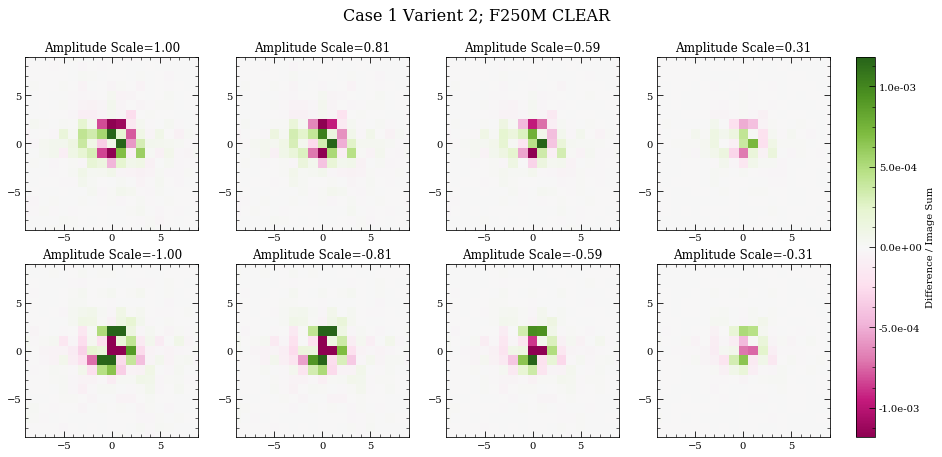

In [18]:
fig, axes = plt.subplots(2,4, figsize=(14,7))
psf0 = psf_list[imid]
vmax = np.abs(psf_list[0] - psf0).max()/2

ind_vals = [0,2,3,4,-1,-3,-4,-5]
for i, ax in enumerate(axes.flatten()):
    ii = ind_vals[i]
    psf = psf_list[ii]
    diff = psf - psf0

    norm = matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax)
    CS = ax.imshow(diff, extent=[-npix/2,npix/2,-npix/2,npix/2], norm=norm, cmap=plt.cm.PiYG, 
                   interpolation='nearest')
    ax.set_title('Amplitude Scale={:.2f}'.format(amp[ii]))
    
    ax.set_xlim([-rads.max(), rads.max()])
    ax.set_ylim([-rads.max(), rads.max()])
    
    ax.xaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])
    
cax = fig.colorbar(CS, ax=axes.ravel().tolist(), format='%.1e', label='Difference / Image Sum', fraction=0.03)
fig.suptitle('Case {} Variant {}; {} {}'.format(case, variant, nrc.filter, nrc.pupil), fontsize=16)

fig.subplots_adjust(left=0.05, right=0.85)
fig.savefig(mod_dir + 'case{}_variant{}_{}_{}_psfdiff.pdf'.
            format(case,variant,nrc.filter, nrc.pupil.replace(' ','')))

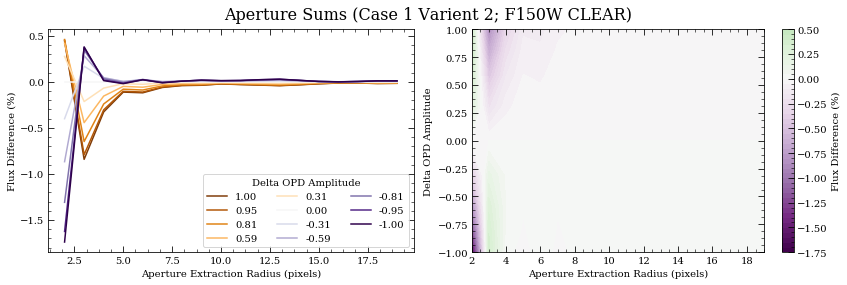

In [203]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

ax = axes[1]
xi = rads
yi = amp[::-1]
zi = 100 * nrc_norm[::-1,:]
vmax = np.abs(zi).max()
CS = ax.contourf(xi, yi, zi, 50, cmap=plt.cm.PRGn, vmax=vmax, vmin=-vmax)
fig.colorbar(CS, ax=ax, label='Flux Difference (%)')
ax.set_xlabel('Aperture Extraction Radius (pixels)')
ax.set_ylabel('Delta OPD Amplitude')

ax = axes[0]
colors = plt.cm.PuOr(np.linspace(0,1,ntime))
for i, ap_sum in enumerate(nrc_norm):
    ax.plot(rads, ap_sum*100, color=colors[i], label='{:.2f}'.format(amp[i]))
ax.set_ylabel('Flux Difference (%)')
ax.set_xlabel('Aperture Extraction Radius (pixels)')
#ax.set_xlim([20,70])
ax.legend(ncol=3, title='Delta OPD Amplitude')

fig.tight_layout()

fig.suptitle('Aperture Sums (Case {} Variant {}; {} {})'.\
             format(case, variant, nrc.filter, nrc.pupil), fontsize=16)
fig.subplots_adjust(top=0.9)

fig.savefig(mod_dir + 'case{}_variant{}_{}_{}_apsum.pdf'.format(case,variant,nrc.filter, nrc.pupil.replace(' ','')))

## Case 1 Variant 2 Multiple Filters

In [26]:
def do_all():
    print(args)
    nrc_list, psf_list = make_nrc_psf(*args)

    npix = psf_list[0].shape[0]

    psf = psf_list[0]
    dist = nrc_utils.dist_image(psf)

    # Determine radial extraction bins
    nrc = nrc_list[0]
    if 'CLEAR' in nrc.pupil:
        w_um = nrc.bandpass.avgwave() / 1e4
        lod_asec = 206265*w_um*1e-6 / 6.5
        lod_pix = lod_asec / nrc.pix_scale
        rad_min = np.max([int(lod_pix), 2])
        rad_max = np.min([5*rad_min, psf.shape[0]/2])
        rads = np.arange(rad_min, rad_max)
    elif 'WEAK' in nrc.pupil:
        rads = np.arange(20, psf.shape[0]/2)

    nrc_sums = []
    for i, nrc in enumerate(nrc_list):
        psf = psf_list[i]

        ap_sum = np.array([np.sum(psf[dist<r]) for r in rads])
        nrc_sums.append(ap_sum)

    nrc_sums = np.array(nrc_sums)

    ntime, naper = nrc_sums.shape

    imid = int(ntime/2)
    nrc_norm = nrc_sums / nrc_sums[imid,:] - 1

    phase = np.linspace(0, np.pi, ntime)
    amp = np.cos(phase)
    #print(amp)

    ### First Plot
    fig, axes = plt.subplots(2,4, figsize=(14,7))
    psf0 = psf_list[imid]
    vmax = np.abs(psf_list[0] - psf0).max()/2

    ind_vals = [0,2,3,4,-1,-3,-4,-5]
    for i, ax in enumerate(axes.flatten()):
        ii = ind_vals[i]
        psf = psf_list[ii]
        diff = psf - psf0

        norm = matplotlib.colors.Normalize(vmin=-vmax, vmax=vmax)
        CS = ax.imshow(diff, extent=[-npix/2,npix/2,-npix/2,npix/2], norm=norm, cmap=plt.cm.PiYG, 
                   interpolation='nearest')
        ax.set_title('Amplitude Scale={:.2f}'.format(amp[ii]))

        ax.set_xlim([-rads.max(), rads.max()])
        ax.set_ylim([-rads.max(), rads.max()])

        ax.xaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])
        ax.yaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])

    cax = fig.colorbar(CS, ax=axes.ravel().tolist(), format='%.1e', 
                       label='Difference / Image Sum', fraction=0.03)
    fig.suptitle('Case {} Variant {}; {} {}'\
                 .format(case, variant, nrc.filter, nrc.pupil), fontsize=16)

    fig.subplots_adjust(left=0.05, right=0.85)
    fig.savefig(mod_dir + 'case{}_variant{}_{}_{}_psfdiff.pdf'.
                format(case,variant,nrc.filter, nrc.pupil.replace(' ','')))


    ### Second Plot
    fig, axes = plt.subplots(1,2, figsize=(12,4))

    ax = axes[1]
    xi = rads
    yi = amp[::-1]
    zi = 100 * nrc_norm[::-1,:]
    vmax = np.abs(zi).max()
    CS = ax.contourf(xi, yi, zi, 50, cmap=plt.cm.PRGn, vmax=vmax, vmin=-vmax)
    fig.colorbar(CS, ax=ax, label='Flux Difference (%)')
    ax.set_xlabel('Aperture Extraction Radius (pixels)')
    ax.set_ylabel('Delta OPD Amplitude')

    ax = axes[0]
    colors = plt.cm.PuOr(np.linspace(0,1,ntime))
    for i, ap_sum in enumerate(nrc_norm):
        ax.plot(rads, ap_sum*100, color=colors[i], label='{:.2f}'.format(amp[i]))
    ax.set_ylabel('Flux Difference (%)')
    ax.set_xlabel('Aperture Extraction Radius (pixels)')
    ax.set_ylim([-1.75,0.5])
    ax.legend(ncol=3, title='Delta OPD Amplitude')

    fig.tight_layout()

    fig.suptitle('Aperture Sums (Case {} Variant {}; {} {})'.\
                 format(case, variant, nrc.filter, nrc.pupil), fontsize=16)
    fig.subplots_adjust(top=0.9)

    fig.savefig(mod_dir + 'case{}_variant{}_{}_{}_apsum.pdf'.\
                format(case,variant,nrc.filter, nrc.pupil.replace(' ','')))

In [ ]:
args_list = [('F070W', None, None, 65),
             ('F150W', None, None, 65),
             ('F200W', None, None, 65),
             ('F210M', None, None, 65),
             ('F212N', None, None, 65),
             ('F444W', None, None, 65),
             ('F430M', None, None, 65),
             ('F405N', None, None, 65),
             ('F356W', None, None, 65),
             ('F335M', None, None, 65),
             ('F250M', None, None, 65)]

args_list = [('F210M', 'WLP8', None, None),
             ('F212N', 'WLP4', None, None)]

for args in args_list:
    do_all()

In [ ]:
args = ('F212N', None, None, 65)
for case in [1,2,3,4]:
    for variant in [1,2,3]:

        mod_dir  = '/Volumes/NIRData/oscillation_opd_models/'
        time_dir = 'time-series-case{}_var{}/'.format(case, variant)
        opd_dir = mod_dir + time_dir

        # All OPD file variations
        opd_files = []
        for file in os.listdir(opd_dir):
            if file.endswith(".fits"):
                opd_files.append(file)
                
        do_all()
